In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import numpy as np
# import sys
# !{sys.executable} -m pip install gym[box2d]
import gym
import Box2D

In [2]:
GPU_NUM = 0
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:{}'.format(GPU_NUM) if use_cuda else "cpu")
transition = np.dtype([('s', np.float64, (4, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96))])
gamma = 0.99
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
print(device)

0
TITAN Xp
cuda:0


In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy,self).__init__()
        self.cnn_layer = nn.Sequential(
                                    nn.Conv2d(4,8,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #48*48*8
                                    nn.ReLU(),
                                    nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #24*24*16
                                    nn.ReLU(),
                                    nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #12*12*32
                                    nn.ReLU(),
                                    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #6*6*64
                                    nn.ReLU(),
                                    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #3*3*128
                                    nn.ReLU(),
                                    nn.Conv2d(128,256,kernel_size=3,padding=0), #1*1*256
                                    nn.ReLU()
                                )
        self.fc_v = nn.Sequential(nn.Linear(256,100), nn.ReLU(),nn.Linear(100,1)) # critic -> for getting value function 
        self.fc_1 = nn.Sequential(nn.Linear(256,100),nn.ReLU()) # Actor -> For getting action
        self.fc_alpha = nn.Sequential(nn.Linear(100,3),nn.Softplus())
        self.fc_beta = nn.Sequential(nn.Linear(100,3),nn.Softplus())
        self.apply(self._init_weight)
       
        
    @staticmethod
    def _init_weight(m): # initializing weight
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)
            
    def forward(self,x):
        x = self.cnn_layer(x)
        x = x.view(-1,256)
        v = self.fc_v(x)
        x = self.fc_1(x)
        alpha = self.fc_alpha(x) + 1 # Beta distribution parameter must be greater than 1
        beta = self.fc_beta(x) + 1   # Beta distribution parameter must be greater than 1
        
        return (alpha, beta), v

In [4]:
class Agent():
    buffer_capacity = 2000 # Save 2000 sequence because max is almost 800 in CarRacing-v0
    ppo_epoch = 10
    batch_size = 64
    clip_param = 0.1 # epsilon in PPO
    
    def __init__(self):
        self.net = Policy().double().to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr = 1e-3)
        self.training_step = 0
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0
    
    def select_action(self,state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample() # 3 values in [0,1]
        a_logp = dist.log_prob(action).sum(dim=1) # For PPO
        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        
        return action, a_logp
      
    def save_param(self):
        torch.save(self.net.state_dict(), '/home/jaekyungcho/DRL/CarRacing/model_param/CarRacing_PPO.pkl')
      
    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity: # If buffer is full return True
            self.counter = 0
            return True
        else:
            return False  # Buffer is not full
        
    def update(self):
        self.training_step += 1
        
        s = torch.tensor(self.buffer['s'], dtype = torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype = torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype = torch.double).to(device).view(-1,1)
        s_ = torch.tensor(self.buffer['s_'], dtype = torch.double).to(device)
        
        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype = torch.double).to(device).view(-1,1)
        
        with torch.no_grad():
            # Using TD(1)
            target_v = r + gamma * self.net(s_)[1] # target value function = reward + value of previous state
            adv = target_v - self.net(s)[1]  # Advantage estimator
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        
        for _ in range(self.ppo_epoch): # Iterate
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                # index는 buffer_capacity를 랜덤으로 섞은 뒤 batch_size로 묶은 것

                (alpha, beta), value = self.net(s[index])
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True) # 현재 state로 구한 action의 probability
                ratio = torch.exp(a_logp - old_a_logp[index])   # surrogate function pi(a_t|s_t)/pi_old(a_t|s_t)

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index] # clipping (0.9~1.1 사이의 ratio로만 policy update를 진행하겠다)
                action_loss = -torch.min(surr1, surr2).mean() # clipped와 unclipped 중 작은 값을 선택 그렇게 함으로써, 너무 큰 변화 없도록 
                value_loss = F.smooth_l1_loss(value, target_v[index]) # smooth l1 loss : [-1,1]범위는 l2 loss 사용
                loss = action_loss + 2. * value_loss # value_loss의 제곱이 되어야 하지만 그냥 l1 norm을 사용한듯 하다.

                self.optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm) # RNN 같은 계열에서 사용해주는 방법 (Gradient가 너무 많이 움직이지 않도록)
                self.optimizer.step()

In [5]:
class Env():
    def __init__(self):
        self.env = gym.make('CarRacing-v0')
        self.env.seed(0)
        self.reward_threshold = self.env.spec.reward_threshold # Car Racing 의 경우 900
    
    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        
        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * 4
        
        return np.array(self.stack)
    
    def step(self, action):
        total_reward = 0
        for i in range(8): # action 을 반복해서 하는 이유는 무엇인가??
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward # CarRacing reward = -0.1/frame
            # if no reward recently, end the episode, 100턴동안 안끝나면
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die
        
    def render(self, *arg):
        self.env.render(*arg)
    
    @staticmethod
    def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray
    
    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def show_score(x,y,i_ep):
    display.clear_output(wait=True)
    plt.figure(4)
    plt.plot(x,y)
    plt.show()
    plt.title("CarRacing | episode: {}".format(i_ep))
    plt.axis('off')
    
    

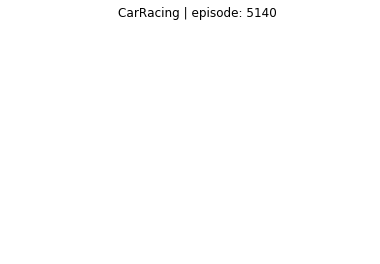

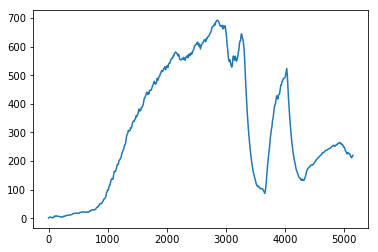

Ep 5150	Last score: 16.97	Moving average score: 219.73
Track generation: 1107..1388 -> 281-tiles track
Track generation: 1213..1520 -> 307-tiles track
Track generation: 1030..1291 -> 261-tiles track
Track generation: 1257..1576 -> 319-tiles track
Track generation: 933..1175 -> 242-tiles track
Track generation: 1099..1378 -> 279-tiles track


In [ ]:
render_env = True
score_x = []
av_score = []

if __name__ == "__main__":
    agent = Agent()
    env = Env()

    training_records = []
    running_score = 0
    for i_ep in range(100000): # episode iteration
        score = 0
        state = env.reset()

        for t in range(1000): # 원래대로라면 t=738에서 끝나야하므로
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            #if render_env:
                #env.render()
                #show_state(env.env)
            if agent.store((state, action, a_logp, reward, state_)): # buffer is full (2000) -> minimum 2 episode
                print('updating')
                agent.update()
            score += reward
            state = state_
            if done or die:
                break
        running_score = running_score * 0.99 + score * 0.01 # moving average

        if i_ep % 10 == 0:
#             if args.vis:
#                 draw_reward(xdata=i_ep, ydata=running_score)
            agent.save_param()
            score_x.append(i_ep)
            av_score.append(running_score)
            show_score(score_x,av_score,i_ep)
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
            
        if running_score > env.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {}!".format(running_score, score))
            break